In [1]:
# pip install tensorflow

In [2]:
# pip install yfinance

### Dependencies

In [4]:
#importing needed libraries

import os
import yfinance as yf
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from pyspark.sql.functions import col,lit,udf,lag 
from pyspark.sql.functions import collect_list, col, size
from pyspark.sql.functions import expr
from pyspark.sql import Row
from pyspark.sql import functions as F
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.sql.window import Window
from pyspark.sql.types import DoubleType
from pyspark.ml.linalg import Vectors, VectorUDT

In [5]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator

In [6]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, GRU, Dropout
from keras.optimizers import Adam
from keras.layers import LSTM, Dense, Dropout
from keras.layers import Dense
from keras.optimizers import Adam

2024-05-06 13:35:16.424986: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-06 13:35:16.444640: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-06 13:35:17.409330: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-06 13:35:19.198147: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-06 13:35:22.633595: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

### Data Preprocessing

In [7]:
#importing data from yahoo finance for tesla stock in 2017
stock = 'TSLA'
stock_data = yf.Ticker(stock )
stock_Df = stock_data.history(period='1d', start='2017-05-01', end='2017-09-12')
stock_Df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-05-01 00:00:00-04:00,20.992001,21.816668,20.987333,21.521999,132444000,0.0,0.0
2017-05-02 00:00:00-04:00,21.600000,21.844000,21.104000,21.259333,80742000,0.0,0.0
2017-05-03 00:00:00-04:00,21.177999,21.435333,20.696667,20.734667,107001000,0.0,0.0
2017-05-04 00:00:00-04:00,20.496000,20.518000,19.384001,19.697332,212280000,0.0,0.0
2017-05-05 00:00:00-04:00,19.866667,20.570000,19.786667,20.556667,122659500,0.0,0.0


In [8]:
#converting df to spark df
sparkDF = spark.createDataFrame(stock_Df.reset_index())
sparkDF.show()

+-------------------+------------------+------------------+------------------+------------------+---------+---------+------------+
|               Date|              Open|              High|               Low|             Close|   Volume|Dividends|Stock Splits|
+-------------------+------------------+------------------+------------------+------------------+---------+---------+------------+
|2017-05-01 04:00:00|20.992000579833984|21.816667556762695|20.987333297729492| 21.52199935913086|132444000|      0.0|         0.0|
|2017-05-02 04:00:00|21.600000381469727|  21.8439998626709|21.104000091552734| 21.25933265686035| 80742000|      0.0|         0.0|
|2017-05-03 04:00:00| 21.17799949645996|21.435333251953125|20.696666717529297| 20.73466682434082|107001000|      0.0|         0.0|
|2017-05-04 04:00:00|20.496000289916992| 20.51799964904785|19.384000778198242| 19.69733238220215|212280000|      0.0|         0.0|
|2017-05-05 04:00:00|19.866666793823242| 20.56999969482422|19.786666870117188| 20.5

In [9]:
#dropping unnecessary columns
sparkDF = sparkDF.drop(*["Dividends", "Stock Splits"])

In [10]:
df = sparkDF

#scaling close price to value between 0 and 1. utilising minmax scaler
assembler = VectorAssembler(inputCols = ["Close"], outputCol = "CloseVec")
vector_df = assembler.transform(df)
scaler = MinMaxScaler(inputCol = "CloseVec", outputCol = "ScaledClosePrices")
scalerModel = scaler.fit(vector_df)
scaled_df = scalerModel.transform(vector_df)
scaled_df.select("Close", "ScaledClosePrices").show()

+------------------+--------------------+
|             Close|   ScaledClosePrices|
+------------------+--------------------+
| 21.52199935913086| [0.311058067797029]|
| 21.25933265686035|[0.26628025468594...|
| 20.73466682434082|[0.17683843205957...|
| 19.69733238220215|               [0.0]|
| 20.55666732788086|[0.1464941664276791]|
|20.479333877563477|[0.13331083273667...|
|21.417333602905273|[0.2932152897407034]|
|21.681333541870117|[0.33822038489026...|
|21.540000915527344|[0.31412686304615...|
| 21.65399932861328|[0.3335606153718093]|
|21.058666229248047|[0.23207186924682...|
|21.134000778198242|[0.24491444245667...|
|20.407333374023438|[0.12103662719957...|
| 20.87066650390625|[0.20002282574978...|
|20.722000122070312|[0.17467909011749...|
|20.690000534057617|[0.16922399604093...|
|20.257333755493164|[0.09546560952880...|
|20.681333541870117|[0.1677465002142759]|
|21.121999740600586|[0.2428685789572599]|
|21.676000595092773|  [0.33731125673636]|
+------------------+--------------

In [11]:
#extracting the number from scaled close price vector
extract = udf(lambda x: float(x[0]), DoubleType())
scaled_df = scaled_df.withColumn("ScaledClosePrices", extract("ScaledClosePrices"))
scaled_df.select("ScaledClosePrices").show(5)

+-------------------+
|  ScaledClosePrices|
+-------------------+
|  0.311058067797029|
|0.26628025468594435|
|0.17683843205957844|
|                0.0|
| 0.1464941664276791|
+-------------------+
only showing top 5 rows



In [12]:
#creating a window of 10 days to get features
windowSpec = Window.orderBy("Date").rowsBetween(-9, 0)
scaled_df = scaled_df.withColumn("features", F.collect_list("ScaledClosePrices").over(windowSpec))

#keeping only the columns that have 10 observations to make a complete feature set
scaled_df = scaled_df.withColumn("count", size("features"))
scaled_df = scaled_df.filter(col("count") == 10)

In [13]:
#dropping count column
scaled_df = scaled_df.drop("count")

In [14]:
#ordering by date column and removing null values
windowSpec = Window.orderBy("Date")
scaled_df = scaled_df.withColumn("label", lag(col("ScaledClosePrices"), -1).over(windowSpec))
scaled_df = scaled_df.filter(col("label").isNotNull())

In [15]:
#repartitioning df by date
scaled_df = scaled_df.repartition("Date")

#calculating max date in 30 day period
max_date = scaled_df.agg(F.max("Date")).collect()[0][0]
threshold_date = max_date - F.expr('INTERVAL 30 DAYS')

#splitting into train and test
train_df = scaled_df.filter(col("Date") <= threshold_date)
test_df = scaled_df.filter(col("Date") > threshold_date)

24/05/06 13:35:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:35:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:35:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:35:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:35:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:35:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 1

In [16]:
#x_train, y_train from train_df
x_train = train_df.select("features")
y_train = train_df.select("label")

#x_test, y_test from test_df
x_test = test_df.select("features")
y_test = test_df.select("label")

## Model Definition and Training

### 1. Baseline Model (Decision Tree Regressor)

In [17]:
#converting array to vector
array_to_vector = udf(lambda x: Vectors.dense(x), VectorUDT())
train_df = train_df.withColumn("features", array_to_vector("features"))
test_df = test_df.withColumn("features", array_to_vector("features"))

In [18]:
#creating a decisiom tree model
dt_model = DecisionTreeRegressor(featuresCol = "features", labelCol = "label")

In [19]:
#noting time as metric
start_time = time.time()

In [20]:
dt_model = dt_model.fit(train_df)

24/05/06 13:35:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:35:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:35:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:35:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:35:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:35:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 1

In [21]:
end_time = time.time()

dt_training_time = end_time - start_time
print("Training time:", dt_training_time, "seconds")

Training time: 5.932264804840088 seconds


In [22]:
#creating predictions on the train and test data
start_time = time.time()
dt_predictions_train = dt_model.transform(train_df)
dt_predictions_test = dt_model.transform(test_df)
end_time = time.time()
dt_prediction_time = end_time - start_time
print("Prediction time:", dt_prediction_time, "seconds")

#calculating mae
mae_evaluator = RegressionEvaluator(labelCol = "label", predictionCol = "prediction", metricName = "mae")
dt_mae = mae_evaluator.evaluate(dt_predictions_test)
print("MAE on test data for Decision Tree model= %g" % dt_mae)

#calculating mse(loss)
mse_evaluator = RegressionEvaluator(labelCol = "label", predictionCol = "prediction", metricName = "mse")
dt_loss = mse_evaluator.evaluate(dt_predictions_test)
print("Loss on test data  Decision Tree model= %g" % dt_loss)

Prediction time: 0.37964582443237305 seconds


24/05/06 13:35:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:35:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:35:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:35:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:35:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:35:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 1

MAE on test data for Decision Tree model= 0.232938


24/05/06 13:35:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:35:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:35:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:35:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:35:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:35:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 1

Loss on test data  Decision Tree model= 0.0690164


In [23]:
def inverse_transform(predictions_df, scaler_model, scaled_col = "ScaledPrediction", original_col = "OriginalPrediction"):
    
    #retaining the original value from scaled value
    original_min = scaler_model.originalMin.toArray()[0]
    original_max = scaler_model.originalMax.toArray()[0]
    range_val = original_max - original_min
    inverse_expr = f"{original_min} + ({scaled_col} * {range_val})"
    restored_df = predictions_df.withColumn( original_col, expr(inverse_expr))
    return restored_df.select("Date","Close", original_col, scaled_col)

#applying function on train anad test predictions
dl_train_predictions_df = inverse_transform(dt_predictions_train, scalerModel, "prediction", "OriginalPrediction")
dl_test_predictions_df = inverse_transform(dt_predictions_test, scalerModel, "prediction", "OriginalPrediction")

In [24]:
train_results = dl_train_predictions_df.select("Date", "Close" ,"OriginalPrediction").withColumnRenamed( "Close" , "Actual").withColumnRenamed("OriginalPrediction", "Predicted")
test_results = dl_test_predictions_df.select("Date","Close","OriginalPrediction").withColumnRenamed( "Close" , "Actual").withColumnRenamed("OriginalPrediction", "Predicted")

In [25]:
#ordering by date
dl_train_predictions_df = dl_train_predictions_df.orderBy("Date")
dl_test_predictions_df = dl_test_predictions_df.orderBy("Date")

#converting to pandas
train_results_pd = dl_train_predictions_df.toPandas()
test_results_pd = dl_test_predictions_df.toPandas()

#formatting date
train_results_pd['Date'] = pd.to_datetime(train_results_pd['Date'])
test_results_pd['Date'] = pd.to_datetime(test_results_pd['Date'])

24/05/06 13:35:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:35:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:35:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:35:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:35:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:35:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 1

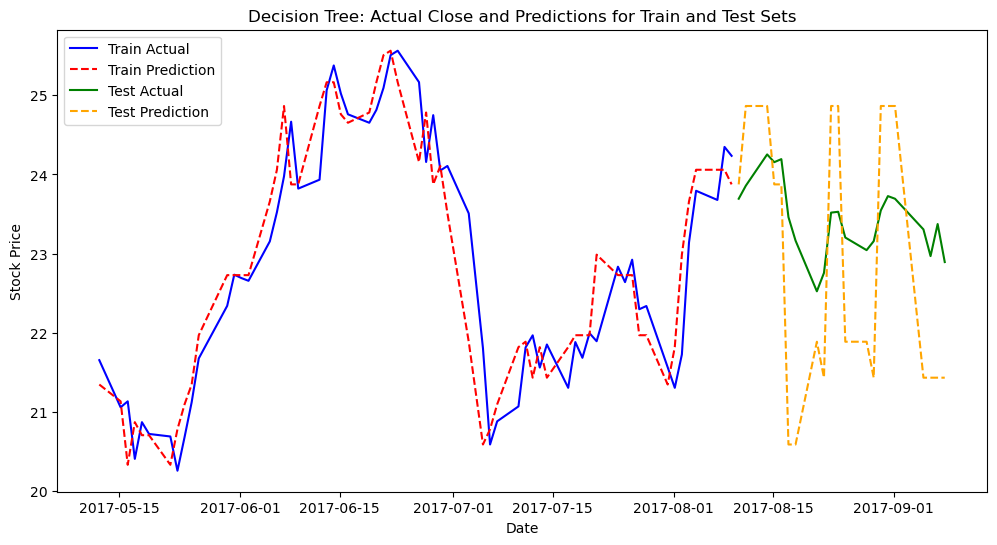

In [26]:
#date as index
train_results_pd.set_index('Date', inplace=True)
test_results_pd.set_index('Date', inplace=True)

#plotting
plt.figure(figsize=(12, 6))
plt.plot(train_results_pd.index, train_results_pd['Close'], label='Train Actual', color='blue')
plt.plot(train_results_pd.index, train_results_pd['OriginalPrediction'], label='Train Prediction', linestyle='--', color='red')
plt.plot(test_results_pd.index, test_results_pd['Close'], label='Test Actual', color='green')
plt.plot(test_results_pd.index, test_results_pd['OriginalPrediction'], label='Test Prediction', linestyle='--', color='orange')
plt.title('Decision Tree: Actual Close and Predictions for Train and Test Sets')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


### 2. LSTM Model

In [27]:
#collecting features and labels
train_features = [row['features'] for row in train_df.select('features').collect()]
train_labels = [row['label'] for row in train_df.select('label').collect()]
test_features = [row['features'] for row in test_df.select('features').collect()]
test_labels = [row['label'] for row in test_df.select('label').collect()]

#reshaping values as needed
x_train = np.array(train_features)
y_train = np.array(train_labels).reshape(-1, 1)
x_test = np.array(test_features)
y_test = np.array(test_labels).reshape(-1, 1)

24/05/06 13:36:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:36:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:36:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:36:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:36:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:36:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 1

In [28]:
input_shape = (x_train.shape[1], 1)

In [29]:
#utilizing mirror strategy with strategy scope for lstm
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    LSTM_model = Sequential([
        LSTM(units=64, return_sequences=True, input_shape=input_shape),
        LSTM(units=64),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(1)
    ])

    LSTM_model.compile(optimizer = Adam(), loss = 'mean_squared_error', metrics = ['mae'])
LSTM_model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,033 (203.25 KB)

 Trainable params: 52,033 (203.25 KB)

 Non-trainable params: 0 (0.00 B)

### 2. CNN Model

In [30]:
#utilizing mirror strategy with strategy scope for cnn

with strategy.scope():
    CNN_model = Sequential([
        Conv1D(filters = 32, kernel_size = 3, activation = 'relu', input_shape = input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(filters = 64, kernel_size = 3, activation = 'relu'),
        MaxPooling1D(pool_size = 2),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1)
        ])
    CNN_model.compile(optimizer = Adam(), loss = 'mean_squared_error', metrics = ['mae'])
CNN_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 8, 32)          │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 4, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2, 64)          │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,561 (41.25 KB)

 Trainable params: 10,561 (41.25 KB)

 Non-trainable params: 0 (0.00 B)

### 3. GRU Model

In [31]:
#utilizing mirror strategy with strategy scope for gru
with strategy.scope():
    GRU_model = Sequential([
        GRU(units = 64, return_sequences = True, input_shape = input_shape),
        GRU(units = 64),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(1)
    ])
    GRU_model.compile(optimizer = Adam(), loss = 'mean_squared_error', metrics = ['mae'])

GRU_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 10, 64)         │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,937 (156.00 KB)

 Trainable params: 39,937 (156.00 KB)

 Non-trainable params: 0 (0.00 B)

## Model Training and Evaluation of Neural Network Models

In [32]:
#creating a fn for decaying learning rate
def decay(epoch):
    if epoch < 30:
        return 1e-2
    else:
        return 1e-2

class PrintLR(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        learning_rate = self.model.optimizer.learning_rate
        print(f"\nlearning rate for epoch {epoch + 1} is {learning_rate}")

In [33]:
#creating checkpoint directories
lstm_checkpoint_dir = './checkpoints/lstm'
cnn_checkpoint_dir = './checkpoints/cnn'
gru_checkpoint_dir = './checkpoints/gru'

#updating the filepath name to end with '.weights.h5'
lstm_checkpoint_prefix = './checkpoints/lstm/ckpt_{epoch}.weights.h5'
cnn_checkpoint_prefix = './checkpoints/lstm/ckpt_{epoch}.weights.h5'
gru_checkpoint_prefix = './checkpoints/lstm/ckpt_{epoch}.weights.h5'

In [34]:
#creating local and hdfs path
local_checkpoint_path = './checkpoints/lstm/ckpt_{epoch}.weights.h5'
hdfs_checkpoint_path = 'hdfs://st446-cluster-w10-m.europe-west2-c.c.st446-414812.internal.:8020/user/username/checkpoints/lstm/'

os.makedirs(os.path.dirname(local_checkpoint_path), exist_ok = True)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = local_checkpoint_path,
    save_weights_only = True,
    save_best_only = False,
    monitor = 'loss',
    verbose = 1,
    mode = 'min',
)

callbacks = [
    checkpoint_callback,
]

In [35]:
#copying filepath from local to hdfs
def copy_checkpoints_to_hdfs(local_path, hdfs_path):
    if os.path.exists(local_path):
        with hdfs.open(hdfs_path, 'w') as dest:
            with open(local_path, 'rb') as src:
                dest.write(src.read())
        print(f"Copied {local_path} to {hdfs_path}")
    else:
        print(f"Local checkpoint {local_path} does not exist.")

In [36]:
#callbacks

lstm_callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='./logs/lstm'),
    tf.keras.callbacks.ModelCheckpoint(filepath=lstm_checkpoint_prefix, save_weights_only=True),
    tf.keras.callbacks.LearningRateScheduler(decay),
    PrintLR()  
]

cnn_callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='./logs/cnn'),
    tf.keras.callbacks.ModelCheckpoint(filepath=cnn_checkpoint_prefix, save_weights_only=True),
    tf.keras.callbacks.LearningRateScheduler(decay),
    PrintLR()
]

gru_callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='./logs/gru'),
    tf.keras.callbacks.ModelCheckpoint(filepath=gru_checkpoint_prefix, save_weights_only=True),
    tf.keras.callbacks.LearningRateScheduler(decay),
    PrintLR()
]

In [37]:
#initialising values
EPOCHS = 50
batch_size = 32

### 1. LSTM

In [38]:
start_time = time.time()

In [39]:
#training lstm model
history1 = LSTM_model.fit(x_train, y_train, batch_size = batch_size , epochs = EPOCHS, callbacks = lstm_callbacks)

Epoch 1/50


2024-05-06 13:36:08.123812: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


1/2 ━━━━━━━━━━━━━━━━━━━━ 5s 6s/step - loss: 0.3656 - mae: 0.5330

2024-05-06 13:36:13.689222: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]



learning rate for epoch 1 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 329ms/step - loss: 0.3132 - mae: 0.4899 - learning_rate: 0.0100
Epoch 2/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.1492 - mae: 0.2939
learning rate for epoch 2 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.1392 - mae: 0.2939 - learning_rate: 0.0100
Epoch 3/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.2136 - mae: 0.4109
learning rate for epoch 3 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.1695 - mae: 0.3464 - learning_rate: 0.0100
Epoch 4/50


2024-05-06 13:36:14.099465: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:36:14.239761: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0925 - mae: 0.2557
learning rate for epoch 4 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0899 - mae: 0.2485 - learning_rate: 0.0100
Epoch 5/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.1657 - mae: 0.3083
learning rate for epoch 5 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.1408 - mae: 0.2905 - learning_rate: 0.0100
Epoch 6/50


2024-05-06 13:36:14.388967: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:36:14.528375: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0583 - mae: 0.2004
learning rate for epoch 6 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0655 - mae: 0.2079 - learning_rate: 0.0100
Epoch 7/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.1098 - mae: 0.2756
learning rate for epoch 7 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0990 - mae: 0.2563 - learning_rate: 0.0100
Epoch 8/50


2024-05-06 13:36:14.675479: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:36:14.820471: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.0651 - mae: 0.1836
learning rate for epoch 8 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0775 - mae: 0.2098 - learning_rate: 0.0100
Epoch 9/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0842 - mae: 0.2351
learning rate for epoch 9 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0768 - mae: 0.2227 - learning_rate: 0.0100
Epoch 10/50


2024-05-06 13:36:14.980150: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:36:15.125657: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.0601 - mae: 0.2225
learning rate for epoch 10 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0601 - mae: 0.2127 - learning_rate: 0.0100
Epoch 11/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0511 - mae: 0.1770
learning rate for epoch 11 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0465 - mae: 0.1670 - learning_rate: 0.0100
Epoch 12/50


2024-05-06 13:36:15.293388: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:36:15.438565: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0708 - mae: 0.2113
learning rate for epoch 12 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0665 - mae: 0.2015 - learning_rate: 0.0100
Epoch 13/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0398 - mae: 0.1566
learning rate for epoch 13 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0483 - mae: 0.1782 - learning_rate: 0.0100


2024-05-06 13:36:15.584549: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:36:15.740470: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


Epoch 14/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0540 - mae: 0.1861
learning rate for epoch 14 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0545 - mae: 0.1895 - learning_rate: 0.0100
Epoch 15/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0776 - mae: 0.2145
learning rate for epoch 15 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0656 - mae: 0.2002 - learning_rate: 0.0100
Epoch 16/50


2024-05-06 13:36:15.894108: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:36:16.041303: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0495 - mae: 0.1767
learning rate for epoch 16 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0460 - mae: 0.1710 - learning_rate: 0.0100
Epoch 17/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0523 - mae: 0.1750
learning rate for epoch 17 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0560 - mae: 0.1852 - learning_rate: 0.0100
Epoch 18/50


2024-05-06 13:36:16.186348: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:36:16.330754: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - loss: 0.0559 - mae: 0.1946
learning rate for epoch 18 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0523 - mae: 0.1853 - learning_rate: 0.0100
Epoch 19/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0386 - mae: 0.1551
learning rate for epoch 19 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0381 - mae: 0.1522 - learning_rate: 0.0100
Epoch 20/50


2024-05-06 13:36:16.635024: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:36:16.782208: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0392 - mae: 0.1558
learning rate for epoch 20 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0410 - mae: 0.1586 - learning_rate: 0.0100
Epoch 21/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0327 - mae: 0.1413
learning rate for epoch 21 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0319 - mae: 0.1408 - learning_rate: 0.0100
Epoch 22/50


2024-05-06 13:36:16.930142: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:36:17.077027: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0450 - mae: 0.1685
learning rate for epoch 22 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0396 - mae: 0.1568 - learning_rate: 0.0100
Epoch 23/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0381 - mae: 0.1524
learning rate for epoch 23 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0362 - mae: 0.1494 - learning_rate: 0.0100


2024-05-06 13:36:17.227801: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:36:17.375750: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


Epoch 24/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.0235 - mae: 0.1210
learning rate for epoch 24 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0224 - mae: 0.1195 - learning_rate: 0.0100
Epoch 25/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0245 - mae: 0.1352
learning rate for epoch 25 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0309 - mae: 0.1466 - learning_rate: 0.0100
Epoch 26/50


2024-05-06 13:36:17.538652: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:36:17.683869: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0323 - mae: 0.1381
learning rate for epoch 26 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0307 - mae: 0.1346 - learning_rate: 0.0100
Epoch 27/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0297 - mae: 0.1385
learning rate for epoch 27 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0278 - mae: 0.1325 - learning_rate: 0.0100


2024-05-06 13:36:17.838540: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:36:17.980059: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


Epoch 28/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0214 - mae: 0.1167
learning rate for epoch 28 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0231 - mae: 0.1208 - learning_rate: 0.0100
Epoch 29/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0415 - mae: 0.1601
learning rate for epoch 29 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0371 - mae: 0.1559 - learning_rate: 0.0100
Epoch 30/50


2024-05-06 13:36:18.139734: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:36:18.288059: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0256 - mae: 0.1311
learning rate for epoch 30 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0312 - mae: 0.1422 - learning_rate: 0.0100
Epoch 31/50


2024-05-06 13:36:18.436241: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - loss: 0.0338 - mae: 0.1551
learning rate for epoch 31 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0302 - mae: 0.1423 - learning_rate: 0.0100
Epoch 32/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0521 - mae: 0.1830
learning rate for epoch 32 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0475 - mae: 0.1734 - learning_rate: 0.0100
Epoch 33/50


2024-05-06 13:36:18.745334: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:36:18.891239: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.0207 - mae: 0.1102
learning rate for epoch 33 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0247 - mae: 0.1221 - learning_rate: 0.0100
Epoch 34/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0273 - mae: 0.1194
learning rate for epoch 34 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0284 - mae: 0.1233 - learning_rate: 0.0100
Epoch 35/50


2024-05-06 13:36:19.079937: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:36:19.230308: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0272 - mae: 0.1311
learning rate for epoch 35 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0259 - mae: 0.1289 - learning_rate: 0.0100
Epoch 36/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0264 - mae: 0.1232
learning rate for epoch 36 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0259 - mae: 0.1260 - learning_rate: 0.0100


2024-05-06 13:36:19.377527: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:36:19.532510: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


Epoch 37/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0218 - mae: 0.1210
learning rate for epoch 37 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0235 - mae: 0.1251 - learning_rate: 0.0100
Epoch 38/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0254 - mae: 0.1352
learning rate for epoch 38 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0258 - mae: 0.1302 - learning_rate: 0.0100
Epoch 39/50


2024-05-06 13:36:19.681921: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:36:19.820269: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.0206 - mae: 0.1095
learning rate for epoch 39 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0236 - mae: 0.1212 - learning_rate: 0.0100
Epoch 40/50


2024-05-06 13:36:20.026340: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - loss: 0.0212 - mae: 0.1188
learning rate for epoch 40 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0230 - mae: 0.1203 - learning_rate: 0.0100
Epoch 41/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0212 - mae: 0.1122
learning rate for epoch 41 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0213 - mae: 0.1127 - learning_rate: 0.0100
Epoch 42/50


2024-05-06 13:36:20.309582: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:36:20.455309: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - loss: 0.0226 - mae: 0.1225
learning rate for epoch 42 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0229 - mae: 0.1236 - learning_rate: 0.0100
Epoch 43/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0276 - mae: 0.1322

2024-05-06 13:36:20.764336: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:36:20.917290: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]



learning rate for epoch 43 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0262 - mae: 0.1253 - learning_rate: 0.0100
Epoch 44/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0240 - mae: 0.1107
learning rate for epoch 44 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0257 - mae: 0.1225 - learning_rate: 0.0100
Epoch 45/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0284 - mae: 0.1339
learning rate for epoch 45 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0273 - mae: 0.1291 - learning_rate: 0.0100
Epoch 46/50


2024-05-06 13:36:21.119170: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:36:21.267884: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.0292 - mae: 0.1280
learning rate for epoch 46 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0257 - mae: 0.1213 - learning_rate: 0.0100
Epoch 47/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0313 - mae: 0.1350
learning rate for epoch 47 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0287 - mae: 0.1327 - learning_rate: 0.0100
Epoch 48/50


2024-05-06 13:36:21.426097: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:36:21.571561: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.0232 - mae: 0.1239
learning rate for epoch 48 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0255 - mae: 0.1262 - learning_rate: 0.0100
Epoch 49/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0242 - mae: 0.1207
learning rate for epoch 49 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0279 - mae: 0.1292 - learning_rate: 0.0100
Epoch 50/50


2024-05-06 13:36:21.726518: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:36:21.872566: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0258 - mae: 0.1271
learning rate for epoch 50 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0252 - mae: 0.1257 - learning_rate: 0.0100


2024-05-06 13:36:22.017302: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


In [40]:
end_time = time.time()

LSTM_training_time = end_time - start_time
print("Training time:", LSTM_training_time, "seconds")

Training time: 14.813937664031982 seconds


In [41]:
#evaluating model
LSTM_loss, LSTM_mae = LSTM_model.evaluate(x_test, y_test)
print('Eval loss: {}, Eval mean absolute error: {}'.format(LSTM_loss, LSTM_mae))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step - loss: 0.0077 - mae: 0.0701
Eval loss: 0.007735810242593288, Eval mean absolute error: 0.07010997831821442


2024-05-06 13:36:22.926334: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


In [42]:
#lstm predictions
start_time = time.time()
LSTM_train_predictions= LSTM_model.predict(x_train)
LSTM_test_predictions = LSTM_model.predict(x_test)
end_time = time.time()
LSTM_prediction_time = end_time - start_time
print("Prediction time:", LSTM_prediction_time,"seconds")

train_data = list(zip(LSTM_train_predictions, train_df.select("Date").collect()))
test_data = list(zip(LSTM_test_predictions, test_df.select("Date").collect()))

#converting to spark df
LSTM_train_predictions_df = spark.createDataFrame([
    (float(pred[0]), date['Date']) for pred, date in train_data
], ["ScaledPrediction", "Date"])
LSTM_test_predictions_df = spark.createDataFrame([
    (float(pred[0]), date['Date']) for pred, date in test_data
], ["ScaledPrediction", "Date"])

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step

2024-05-06 13:36:23.371621: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


2024-05-06 13:36:23.835252: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
24/05/06 13:36:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:36:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:36:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:36:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Prediction time: 0.8961780071258545 seconds


24/05/06 13:36:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:36:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:36:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:36:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:36:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:36:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 1

In [43]:
LSTM_train_predictions_df.show(5)
LSTM_test_predictions_df.show(5)

+-------------------+-------------------+
|   ScaledPrediction|               Date|
+-------------------+-------------------+
| 0.6248562335968018|2017-08-04 04:00:00|
|0.30303308367729187|2017-07-11 04:00:00|
|0.34547117352485657|2017-05-26 04:00:00|
|0.27620795369148254|2017-05-18 04:00:00|
| 0.9363499879837036|2017-06-23 04:00:00|
+-------------------+-------------------+
only showing top 5 rows

+------------------+-------------------+
|  ScaledPrediction|               Date|
+------------------+-------------------+
|0.5870379209518433|2017-08-28 04:00:00|
|0.5496363639831543|2017-09-08 04:00:00|
|0.5945859551429749|2017-08-18 04:00:00|
|0.7286917567253113|2017-08-15 04:00:00|
|0.6495096683502197|2017-08-31 04:00:00|
+------------------+-------------------+
only showing top 5 rows



In [44]:
def inverse_transform_scaled_predictions(predictions_df, scaler_model, scaled_col = "ScaledPrediction", original_col = "OriginalPrediction"):
    original_min = scaler_model.originalMin.toArray()[0]
    original_max = scaler_model.originalMax.toArray()[0]
    range_val = original_max - original_min
    restored_df = predictions_df.withColumn(
        original_col,
        expr(f"{original_min} + {range_val} * {scaled_col}")
    )
    return restored_df.select(predictions_df["Date"], original_col, scaled_col)


LSTM_train_predictions_df = inverse_transform_scaled_predictions(LSTM_train_predictions_df, scalerModel)
LSTM_test_predictions_df = inverse_transform_scaled_predictions(LSTM_test_predictions_df, scalerModel)
LSTM_train_predictions_df.show()
LSTM_test_predictions_df.show()

+-------------------+------------------+-------------------+
|               Date|OriginalPrediction|   ScaledPrediction|
+-------------------+------------------+-------------------+
|2017-08-04 04:00:00|23.362739754037648| 0.6248562335968018|
|2017-07-11 04:00:00|21.474924793223067|0.30303308367729187|
|2017-05-26 04:00:00|21.723866676187868|0.34547117352485657|
|2017-05-18 04:00:00|21.317568550436704|0.27620795369148254|
|2017-06-23 04:00:00| 25.18996246899451| 0.9363499879837036|
|2017-05-25 04:00:00|21.374633269117567|0.28593599796295166|
|2017-06-16 04:00:00|24.802947738907733| 0.8703740835189819|
|2017-07-20 04:00:00|22.033682091125343| 0.3982866108417511|
|2017-05-30 04:00:00|22.245611161801662|0.43441498279571533|
|2017-07-27 04:00:00|22.722736397052586|  0.515752375125885|
|2017-07-31 04:00:00|22.022266664938684|0.39634057879447937|
|2017-06-01 04:00:00| 22.97305761342136| 0.5584256052970886|
|2017-05-22 04:00:00|21.321648685077434|0.27690351009368896|
|2017-08-01 04:00:00| 21

In [45]:
#creating new dataframe with prediction
def create_prediction_dataframe(scaled_df, predictions_df, scaler_model):
    original_predictions_df = inverse_transform_scaled_predictions(predictions_df, scaler_model)
    merged_df = scaled_df.join(original_predictions_df, on="Date", how="inner")
    result_df = merged_df.select("Date", "Close", "OriginalPrediction")
    return result_df

#training data
LSTM_train_result_df = create_prediction_dataframe(scaled_df, LSTM_train_predictions_df, scalerModel)
LSTM_train_result_df.show()

#testing data
LSTM_test_result_df = create_prediction_dataframe(scaled_df, LSTM_test_predictions_df, scalerModel)
LSTM_test_result_df.show()

24/05/06 13:36:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:36:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:36:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:36:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:36:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:36:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 1

+-------------------+------------------+------------------+
|               Date|             Close|OriginalPrediction|
+-------------------+------------------+------------------+
|2017-08-04 04:00:00| 23.79400062561035|23.362739754037648|
|2017-07-11 04:00:00|21.814666748046875|21.474924793223067|
|2017-05-26 04:00:00|21.676000595092773|21.723866676187868|
|2017-05-18 04:00:00| 20.87066650390625|21.317568550436704|
|2017-06-23 04:00:00| 25.56333351135254| 25.18996246899451|
|2017-05-25 04:00:00|21.121999740600586|21.374633269117567|
|2017-06-16 04:00:00|24.760000228881836|24.802947738907733|
|2017-07-20 04:00:00|21.994667053222656|22.033682091125343|
|2017-05-30 04:00:00| 22.34000015258789|22.245611161801662|
|2017-07-27 04:00:00|22.297332763671875|22.722736397052586|
|2017-07-31 04:00:00|21.564666748046875|22.022266664938684|
|2017-06-01 04:00:00|22.691333770751953| 22.97305761342136|
|2017-05-22 04:00:00|20.690000534057617|21.321648685077434|
|2017-08-01 04:00:00| 21.30466651916504|

24/05/06 13:36:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:36:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:36:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:36:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:36:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:36:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 1

+-------------------+------------------+------------------+
|               Date|             Close|OriginalPrediction|
+-------------------+------------------+------------------+
|2017-08-28 04:00:00| 23.04400062561035| 23.14089748935976|
|2017-09-08 04:00:00|22.893333435058594|22.921499913949447|
|2017-08-18 04:00:00|23.163999557495117|23.185174266447802|
|2017-08-15 04:00:00|24.155332565307617|23.971839049955406|
|2017-08-31 04:00:00|23.726667404174805|23.507356830138633|
|2017-08-17 04:00:00|23.461332321166992|23.635854760842903|
|2017-09-07 04:00:00|23.374000549316406|23.094305739783067|
|2017-08-14 04:00:00|24.253332138061523|23.913389928077322|
|2017-09-01 04:00:00| 23.69333267211914|23.627416527035166|
|2017-08-16 04:00:00|24.194000244140625|24.010687302219594|
|2017-08-25 04:00:00|23.203332901000977| 23.29191369346063|
|2017-09-05 04:00:00|23.305999755859375| 23.44993670146914|
|2017-09-06 04:00:00|22.968666076660156| 23.10203350325446|
|2017-08-11 04:00:00|23.857999801635742|

In [46]:
#ordering by date
LSTM_train_result_df = LSTM_train_result_df.orderBy("Date")
LSTM_test_result_df = LSTM_test_result_df.orderBy("Date")

In [47]:
#extracting needed values
train_data = LSTM_train_result_df.select("Date", "Close", "OriginalPrediction").collect()
train_dates = [row["Date"] for row in train_data]
train_close = [row["Close"] for row in train_data]
LSTM_train_predictions = [row["OriginalPrediction"] for row in train_data]

test_data = LSTM_test_result_df.select("Date", "Close", "OriginalPrediction").collect()
test_dates = [row["Date"] for row in test_data]
test_close = [row["Close"] for row in test_data]
LSTM_test_predictions = [row["OriginalPrediction"] for row in test_data]

24/05/06 13:36:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:36:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:36:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:36:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:36:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:36:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 1

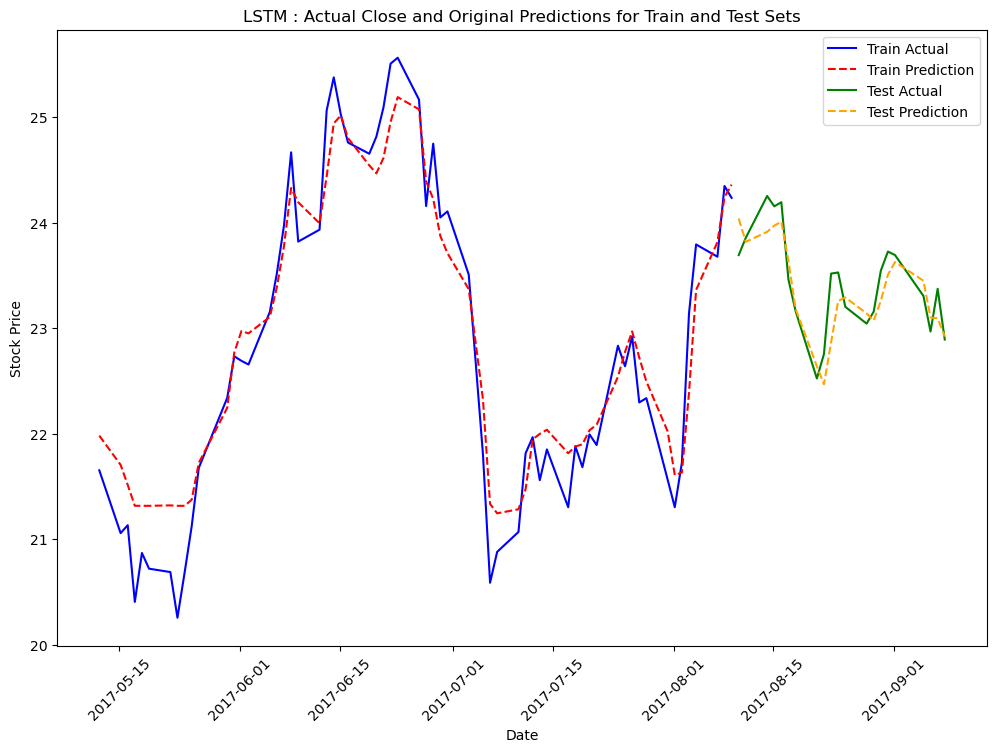

In [48]:
#plotting
plt.figure(figsize=(12, 8))

plt.plot(train_dates, train_close, label='Train Actual', color='blue')
plt.plot(train_dates, LSTM_train_predictions, label='Train Prediction', color='red', linestyle='--')
plt.plot(test_dates, test_close, label='Test Actual', color='green')
plt.plot(test_dates, LSTM_test_predictions, label='Test Prediction', color='orange', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('LSTM : Actual Close and Original Predictions for Train and Test Sets')
plt.legend()
plt.xticks(rotation=45)

# Show the plot
plt.show()

## 2. CNN

In [49]:
start_time = time.time()

In [50]:
history2 = CNN_model.fit(x_train, y_train, batch_size = batch_size , epochs=EPOCHS, callbacks = cnn_callbacks)

Epoch 1/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2663 - mae: 0.4689
learning rate for epoch 1 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.2053 - mae: 0.3859 - learning_rate: 0.0100
Epoch 2/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0516 - mae: 0.1777
learning rate for epoch 2 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0519 - mae: 0.1838 - learning_rate: 0.0100
Epoch 3/50


2024-05-06 13:36:34.484819: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:36:34.616769: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0548 - mae: 0.1925
learning rate for epoch 3 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0477 - mae: 0.1806 - learning_rate: 0.0100
Epoch 4/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0406 - mae: 0.1620
learning rate for epoch 4 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0424 - mae: 0.1663 - learning_rate: 0.0100
Epoch 5/50


2024-05-06 13:36:34.742427: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:36:34.869627: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0348 - mae: 0.1533
learning rate for epoch 5 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0371 - mae: 0.1596 - learning_rate: 0.0100
Epoch 6/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0398 - mae: 0.1640
learning rate for epoch 6 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0386 - mae: 0.1638 - learning_rate: 0.0100
Epoch 7/50


2024-05-06 13:36:34.996891: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:36:35.127157: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0311 - mae: 0.1344
learning rate for epoch 7 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0340 - mae: 0.1424 - learning_rate: 0.0100
Epoch 8/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0298 - mae: 0.1403
learning rate for epoch 8 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0295 - mae: 0.1388 - learning_rate: 0.0100
Epoch 9/50


2024-05-06 13:36:35.253750: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:36:35.385190: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0268 - mae: 0.1289
learning rate for epoch 9 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0282 - mae: 0.1336 - learning_rate: 0.0100
Epoch 10/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0385 - mae: 0.1474
learning rate for epoch 10 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0321 - mae: 0.1334 - learning_rate: 0.0100
Epoch 11/50


2024-05-06 13:36:35.509536: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:36:35.633401: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0153 - mae: 0.1008
learning rate for epoch 11 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0204 - mae: 0.1130 - learning_rate: 0.0100
Epoch 12/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0216 - mae: 0.1150
learning rate for epoch 12 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0220 - mae: 0.1157 - learning_rate: 0.0100
Epoch 13/50


2024-05-06 13:36:35.763633: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:36:35.892495: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0247 - mae: 0.1248
learning rate for epoch 13 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0215 - mae: 0.1166 - learning_rate: 0.0100
Epoch 14/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0225 - mae: 0.1145
learning rate for epoch 14 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0202 - mae: 0.1124 - learning_rate: 0.0100
Epoch 15/50


2024-05-06 13:36:36.022935: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:36:36.147108: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0210 - mae: 0.1189
learning rate for epoch 15 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0196 - mae: 0.1119 - learning_rate: 0.0100
Epoch 16/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0150 - mae: 0.0972
learning rate for epoch 16 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0161 - mae: 0.1010 - learning_rate: 0.0100
Epoch 17/50


2024-05-06 13:36:36.273320: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:36:36.395432: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0124 - mae: 0.0905
learning rate for epoch 17 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0167 - mae: 0.1014 - learning_rate: 0.0100
Epoch 18/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.0178 - mae: 0.1064
learning rate for epoch 18 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0202 - mae: 0.1150 - learning_rate: 0.0100
Epoch 19/50


2024-05-06 13:36:36.522806: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:36:36.664824: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0126 - mae: 0.0935
learning rate for epoch 19 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0170 - mae: 0.1024 - learning_rate: 0.0100
Epoch 20/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0173 - mae: 0.1102
learning rate for epoch 20 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0167 - mae: 0.1072 - learning_rate: 0.0100
Epoch 21/50


2024-05-06 13:36:36.803241: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:36:36.937207: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0130 - mae: 0.0907
learning rate for epoch 21 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0137 - mae: 0.0953 - learning_rate: 0.0100
Epoch 22/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0263 - mae: 0.1314
learning rate for epoch 22 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0208 - mae: 0.1137 - learning_rate: 0.0100
Epoch 23/50


2024-05-06 13:36:37.076887: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:36:37.203038: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0108 - mae: 0.0886
learning rate for epoch 23 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0150 - mae: 0.0992 - learning_rate: 0.0100
Epoch 24/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0116 - mae: 0.0883
learning rate for epoch 24 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0153 - mae: 0.0954 - learning_rate: 0.0100
Epoch 25/50


2024-05-06 13:36:37.331413: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:36:37.465536: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0161 - mae: 0.0981
learning rate for epoch 25 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0149 - mae: 0.0961 - learning_rate: 0.0100
Epoch 26/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0165 - mae: 0.0989
learning rate for epoch 26 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0156 - mae: 0.0973 - learning_rate: 0.0100
Epoch 27/50


2024-05-06 13:36:37.589079: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:36:37.718278: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0159 - mae: 0.0987
learning rate for epoch 27 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0151 - mae: 0.0977 - learning_rate: 0.0100
Epoch 28/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.0100 - mae: 0.0801
learning rate for epoch 28 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0147 - mae: 0.0941 - learning_rate: 0.0100
Epoch 29/50


2024-05-06 13:36:37.858893: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:36:38.003571: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.0132 - mae: 0.0938
learning rate for epoch 29 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0130 - mae: 0.0909 - learning_rate: 0.0100
Epoch 30/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0127 - mae: 0.0905
learning rate for epoch 30 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0128 - mae: 0.0917 - learning_rate: 0.0100
Epoch 31/50


2024-05-06 13:36:38.154651: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:36:38.250782: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-05-06 13:36:38.282253: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0151 - mae: 0.0957
learning rate for epoch 31 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0146 - mae: 0.0955 - learning_rate: 0.0100
Epoch 32/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0132 - mae: 0.0940
learning rate for epoch 32 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0139 - mae: 0.0979 - learning_rate: 0.0100
Epoch 33/50


2024-05-06 13:36:38.409101: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:36:38.537019: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0138 - mae: 0.0927
learning rate for epoch 33 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0129 - mae: 0.0900 - learning_rate: 0.0100
Epoch 34/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0149 - mae: 0.0984
learning rate for epoch 34 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0131 - mae: 0.0920 - learning_rate: 0.0100
Epoch 35/50


2024-05-06 13:36:38.668726: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:36:38.791546: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0115 - mae: 0.0832
learning rate for epoch 35 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0120 - mae: 0.0878 - learning_rate: 0.0100
Epoch 36/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0076 - mae: 0.0723
learning rate for epoch 36 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0093 - mae: 0.0790 - learning_rate: 0.0100
Epoch 37/50


2024-05-06 13:36:38.917289: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:36:39.052298: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.0079 - mae: 0.0688
learning rate for epoch 37 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0091 - mae: 0.0760 - learning_rate: 0.0100
Epoch 38/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0081 - mae: 0.0744
learning rate for epoch 38 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0093 - mae: 0.0795 - learning_rate: 0.0100
Epoch 39/50


2024-05-06 13:36:39.196614: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:36:39.323216: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0098 - mae: 0.0790
learning rate for epoch 39 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0096 - mae: 0.0786 - learning_rate: 0.0100
Epoch 40/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0077 - mae: 0.0711
learning rate for epoch 40 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0090 - mae: 0.0773 - learning_rate: 0.0100
Epoch 41/50


2024-05-06 13:36:39.457920: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:36:39.577271: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.0108 - mae: 0.0866
learning rate for epoch 41 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0099 - mae: 0.0807 - learning_rate: 0.0100
Epoch 42/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0094 - mae: 0.0785
learning rate for epoch 42 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0087 - mae: 0.0758 - learning_rate: 0.0100
Epoch 43/50


2024-05-06 13:36:39.725267: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:36:39.873114: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0091 - mae: 0.0750
learning rate for epoch 43 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0090 - mae: 0.0765 - learning_rate: 0.0100
Epoch 44/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.0113 - mae: 0.0897

2024-05-06 13:36:40.018633: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:36:40.214952: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]



learning rate for epoch 44 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0099 - mae: 0.0806 - learning_rate: 0.0100
Epoch 45/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0090 - mae: 0.0835
learning rate for epoch 45 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0093 - mae: 0.0810 - learning_rate: 0.0100
Epoch 46/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.0096 - mae: 0.0794
learning rate for epoch 46 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0086 - mae: 0.0752 - learning_rate: 0.0100
Epoch 47/50


2024-05-06 13:36:40.346282: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:36:40.490109: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0096 - mae: 0.0816
learning rate for epoch 47 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0105 - mae: 0.0844 - learning_rate: 0.0100
Epoch 48/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.0077 - mae: 0.0723
learning rate for epoch 48 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0109 - mae: 0.0835 - learning_rate: 0.0100
Epoch 49/50


2024-05-06 13:36:40.611311: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:36:40.756304: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0083 - mae: 0.0775
learning rate for epoch 49 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0082 - mae: 0.0754 - learning_rate: 0.0100
Epoch 50/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.0110 - mae: 0.0864

2024-05-06 13:36:40.894047: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:36:41.053348: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]



learning rate for epoch 50 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - loss: 0.0106 - mae: 0.0856 - learning_rate: 0.0100


In [51]:
end_time = time.time()

CNN_training_time = end_time - start_time
print("Training time:", CNN_training_time, "seconds")

Training time: 10.99051308631897 seconds


In [52]:
#evaluating
CNN_loss, CNN_mae = CNN_model.evaluate(x_test, y_test)
print('Eval loss: {}, Eval mean absolute error: {}'.format(CNN_loss, CNN_mae))

2024-05-06 13:36:45.579762: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0142 - mae: 0.0922
Eval loss: 0.014216411858797073, Eval mean absolute error: 0.09224684536457062


In [53]:
#making predictions
start_time = time.time()
CNN_train_predictions= CNN_model.predict(x_train)
CNN_test_predictions = CNN_model.predict(x_test)
end_time = time.time()
CNN_prediction_time = end_time - start_time
print("Prediction time:", CNN_prediction_time,"seconds")

train_data = list(zip(CNN_train_predictions, train_df.select("Date").collect()))
test_data = list(zip(CNN_test_predictions, test_df.select("Date").collect()))

CNN_train_predictions_df = spark.createDataFrame([
    (float(pred[0]), date['Date']) for pred, date in train_data
], ["ScaledPrediction", "Date"])
CNN_test_predictions_df = spark.createDataFrame([
    (float(pred[0]), date['Date']) for pred, date in test_data
], ["ScaledPrediction", "Date"])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


2024-05-06 13:36:46.593703: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Prediction time: 1.1757032871246338 seconds


2024-05-06 13:36:47.297974: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
24/05/06 13:36:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:36:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:36:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:36:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:36:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause seri

In [54]:
CNN_train_predictions_df.show()
CNN_test_predictions_df.show()

+-------------------+-------------------+
|   ScaledPrediction|               Date|
+-------------------+-------------------+
| 0.6648397445678711|2017-08-04 04:00:00|
|0.30483338236808777|2017-07-11 04:00:00|
| 0.2893039286136627|2017-05-26 04:00:00|
|0.18463528156280518|2017-05-18 04:00:00|
| 0.8245612978935242|2017-06-23 04:00:00|
|0.20453280210494995|2017-05-25 04:00:00|
| 0.9045676589012146|2017-06-16 04:00:00|
| 0.3291316628456116|2017-07-20 04:00:00|
|0.37870675325393677|2017-05-30 04:00:00|
|  0.502699077129364|2017-07-27 04:00:00|
|0.32161977887153625|2017-07-31 04:00:00|
| 0.4698305130004883|2017-06-01 04:00:00|
|0.17418122291564941|2017-05-22 04:00:00|
|0.27702051401138306|2017-08-01 04:00:00|
| 0.6779503226280212|2017-06-07 04:00:00|
|0.21774569153785706|2017-07-14 04:00:00|
| 0.3143239915370941|2017-07-05 04:00:00|
| 0.6798428893089294|2017-08-09 04:00:00|
|0.22954392433166504|2017-05-12 04:00:00|
| 0.2707773745059967|2017-07-18 04:00:00|
+-------------------+-------------

In [55]:
CNN_train_predictions_df = inverse_transform_scaled_predictions(CNN_train_predictions_df, scalerModel)
CNN_test_predictions_df = inverse_transform_scaled_predictions(CNN_test_predictions_df, scalerModel)
CNN_train_predictions_df.show(5)
CNN_test_predictions_df.show(5)

+-------------------+------------------+-------------------+
|               Date|OriginalPrediction|   ScaledPrediction|
+-------------------+------------------+-------------------+
|2017-08-04 04:00:00|23.597283074541338| 0.6648397445678711|
|2017-07-11 04:00:00|21.485485347376084|0.30483338236808777|
|2017-05-26 04:00:00|21.394389554117538| 0.2893039286136627|
|2017-05-18 04:00:00|20.780403152330564|0.18463528156280518|
|2017-06-23 04:00:00|24.534209886699273| 0.8245612978935242|
+-------------------+------------------+-------------------+
only showing top 5 rows

+-------------------+------------------+------------------+
|               Date|OriginalPrediction|  ScaledPrediction|
+-------------------+------------------+------------------+
|2017-08-28 04:00:00|23.002122563283365|0.5633804202079773|
|2017-09-08 04:00:00|22.695611254978985|0.5111282467842102|
|2017-08-18 04:00:00|  22.7796257708153|0.5254505276679993|
|2017-08-15 04:00:00|23.693885712188376|0.6813079714775085|
|2017-

In [56]:
CNN_train_result_df = create_prediction_dataframe(scaled_df, CNN_train_predictions_df, scalerModel)
CNN_train_result_df.show(5)

CNN_test_result_df = create_prediction_dataframe(scaled_df, CNN_test_predictions_df, scalerModel)
CNN_test_result_df.show(5)

24/05/06 13:36:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:36:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:36:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:36:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:36:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:36:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 1

+-------------------+------------------+------------------+
|               Date|             Close|OriginalPrediction|
+-------------------+------------------+------------------+
|2017-08-04 04:00:00| 23.79400062561035|23.597283074541338|
|2017-07-11 04:00:00|21.814666748046875|21.485485347376084|
|2017-05-26 04:00:00|21.676000595092773|21.394389554117538|
|2017-05-18 04:00:00| 20.87066650390625|20.780403152330564|
|2017-06-23 04:00:00| 25.56333351135254|24.534209886699273|
+-------------------+------------------+------------------+
only showing top 5 rows



24/05/06 13:36:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:36:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:36:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:36:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:36:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:36:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 1

+-------------------+------------------+------------------+
|               Date|             Close|OriginalPrediction|
+-------------------+------------------+------------------+
|2017-08-25 04:00:00|23.203332901000977|23.163160874530377|
|2017-09-05 04:00:00|23.305999755859375|23.356233286277302|
|2017-09-06 04:00:00|22.968666076660156|22.978602918310344|
|2017-08-11 04:00:00|23.857999801635742|23.720653521248323|
|2017-08-10 04:00:00| 23.69333267211914| 23.56231583641761|
+-------------------+------------------+------------------+
only showing top 5 rows



In [57]:
# order by date
CNN_train_result_df = CNN_train_result_df.orderBy("Date")
CNN_test_result_df = CNN_test_result_df.orderBy("Date")

In [58]:
train_data = CNN_train_result_df.select("Date", "Close", "OriginalPrediction").collect()
train_dates = [row["Date"] for row in train_data]
train_close = [row["Close"] for row in train_data]
CNN_train_predictions = [row["OriginalPrediction"] for row in train_data]

test_data = CNN_test_result_df.select("Date", "Close", "OriginalPrediction").collect()
test_dates = [row["Date"] for row in test_data]
test_close = [row["Close"] for row in test_data]
CNN_test_predictions = [row["OriginalPrediction"] for row in test_data]

24/05/06 13:36:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:36:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:36:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:36:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:36:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:36:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 1

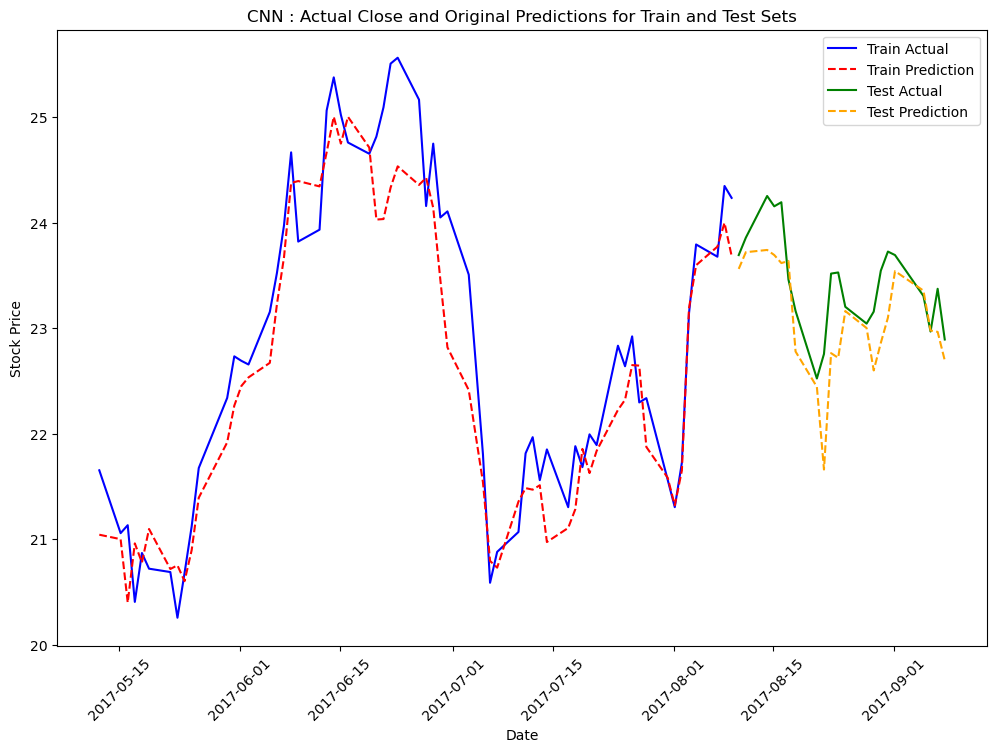

In [59]:
#plotting
plt.figure(figsize=(12, 8))

plt.plot(train_dates, train_close, label='Train Actual', color='blue')
plt.plot(train_dates, CNN_train_predictions, label='Train Prediction', color='red', linestyle='--')
plt.plot(test_dates, test_close, label='Test Actual', color='green')
plt.plot(test_dates, CNN_test_predictions, label='Test Prediction', color='orange', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('CNN : Actual Close and Original Predictions for Train and Test Sets')
plt.legend()
plt.xticks(rotation=45)
plt.show()

## 3. GRU

In [60]:
start_time = time.time()

In [61]:
history3 = GRU_model.fit(x_train, y_train, batch_size = batch_size , epochs=EPOCHS, callbacks = gru_callbacks)

Epoch 1/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - loss: 0.4172 - mae: 0.5850

2024-05-06 13:37:07.359026: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]



learning rate for epoch 1 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 621ms/step - loss: 0.3336 - mae: 0.4879 - learning_rate: 0.0100
Epoch 2/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0604 - mae: 0.1893
learning rate for epoch 2 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - loss: 0.1129 - mae: 0.2517 - learning_rate: 0.0100
Epoch 3/50


2024-05-06 13:37:09.458099: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.1052 - mae: 0.2583
learning rate for epoch 3 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0997 - mae: 0.2511 - learning_rate: 0.0100
Epoch 4/50


2024-05-06 13:37:09.686767: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-05-06 13:37:09.760985: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - loss: 0.0678 - mae: 0.1748
learning rate for epoch 4 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0768 - mae: 0.2012 - learning_rate: 0.0100
Epoch 5/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0578 - mae: 0.1993
learning rate for epoch 5 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0524 - mae: 0.1875 - learning_rate: 0.0100
Epoch 6/50


2024-05-06 13:37:10.044016: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:37:10.193537: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0800 - mae: 0.1973
learning rate for epoch 6 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0734 - mae: 0.1982 - learning_rate: 0.0100
Epoch 7/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0694 - mae: 0.2125

2024-05-06 13:37:10.339927: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:37:10.485099: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]



learning rate for epoch 7 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0822 - mae: 0.2322 - learning_rate: 0.0100
Epoch 8/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.0463 - mae: 0.1464
learning rate for epoch 8 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0413 - mae: 0.1405 - learning_rate: 0.0100
Epoch 9/50


2024-05-06 13:37:10.724063: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - loss: 0.0475 - mae: 0.1636
learning rate for epoch 9 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0482 - mae: 0.1668 - learning_rate: 0.0100
Epoch 10/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0293 - mae: 0.1391
learning rate for epoch 10 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0391 - mae: 0.1538 - learning_rate: 0.0100
Epoch 11/50


2024-05-06 13:37:11.018780: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:37:11.167797: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0308 - mae: 0.1326
learning rate for epoch 11 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0339 - mae: 0.1399 - learning_rate: 0.0100
Epoch 12/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.0494 - mae: 0.1582
learning rate for epoch 12 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0424 - mae: 0.1517 - learning_rate: 0.0100


2024-05-06 13:37:11.315014: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:37:11.467861: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


Epoch 13/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - loss: 0.0345 - mae: 0.1456
learning rate for epoch 13 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0387 - mae: 0.1559 - learning_rate: 0.0100
Epoch 14/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0332 - mae: 0.1412
learning rate for epoch 14 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0412 - mae: 0.1520 - learning_rate: 0.0100
Epoch 15/50


2024-05-06 13:37:11.775843: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:37:11.920699: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.0240 - mae: 0.1226
learning rate for epoch 15 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0249 - mae: 0.1263 - learning_rate: 0.0100
Epoch 16/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0373 - mae: 0.1378

2024-05-06 13:37:12.072884: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:37:12.224364: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]



learning rate for epoch 16 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0330 - mae: 0.1290 - learning_rate: 0.0100
Epoch 17/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - loss: 0.0268 - mae: 0.1267
learning rate for epoch 17 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0226 - mae: 0.1183 - learning_rate: 0.0100
Epoch 18/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0275 - mae: 0.1323
learning rate for epoch 18 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0275 - mae: 0.1303 - learning_rate: 0.0100
Epoch 19/50


2024-05-06 13:37:12.529812: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:37:12.675262: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0194 - mae: 0.1001
learning rate for epoch 19 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0207 - mae: 0.1030 - learning_rate: 0.0100
Epoch 20/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0249 - mae: 0.1243
learning rate for epoch 20 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0229 - mae: 0.1159 - learning_rate: 0.0100
Epoch 21/50


2024-05-06 13:37:12.818494: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:37:12.958796: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0311 - mae: 0.1310
learning rate for epoch 21 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0284 - mae: 0.1285 - learning_rate: 0.0100
Epoch 22/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0392 - mae: 0.1476
learning rate for epoch 22 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0315 - mae: 0.1329 - learning_rate: 0.0100
Epoch 23/50


2024-05-06 13:37:13.106347: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:37:13.247494: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - loss: 0.0288 - mae: 0.1319
learning rate for epoch 23 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0247 - mae: 0.1213 - learning_rate: 0.0100
Epoch 24/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0314 - mae: 0.1340
learning rate for epoch 24 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0303 - mae: 0.1309 - learning_rate: 0.0100
Epoch 25/50


2024-05-06 13:37:13.553772: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:37:13.697995: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - loss: 0.0410 - mae: 0.1433
learning rate for epoch 25 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0422 - mae: 0.1482 - learning_rate: 0.0100
Epoch 26/50


2024-05-06 13:37:14.003363: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 0.0316 - mae: 0.1264
learning rate for epoch 26 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0323 - mae: 0.1321 - learning_rate: 0.0100
Epoch 27/50


2024-05-06 13:37:14.373190: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.0386 - mae: 0.1564
learning rate for epoch 27 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0289 - mae: 0.1298 - learning_rate: 0.0100
Epoch 28/50


2024-05-06 13:37:14.659367: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - loss: 0.0407 - mae: 0.1526
learning rate for epoch 28 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0412 - mae: 0.1554 - learning_rate: 0.0100
Epoch 29/50


2024-05-06 13:37:14.981635: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - loss: 0.0353 - mae: 0.1345
learning rate for epoch 29 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0320 - mae: 0.1312 - learning_rate: 0.0100
Epoch 30/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.0407 - mae: 0.1485

2024-05-06 13:37:15.304547: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:37:15.475721: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]



learning rate for epoch 30 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0450 - mae: 0.1561 - learning_rate: 0.0100
Epoch 31/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0328 - mae: 0.1354
learning rate for epoch 31 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0325 - mae: 0.1369 - learning_rate: 0.0100
Epoch 32/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0254 - mae: 0.1254
learning rate for epoch 32 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0234 - mae: 0.1174 - learning_rate: 0.0100
Epoch 33/50


2024-05-06 13:37:15.615915: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:37:15.757896: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0307 - mae: 0.1307
learning rate for epoch 33 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0297 - mae: 0.1309 - learning_rate: 0.0100
Epoch 34/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0212 - mae: 0.1189

2024-05-06 13:37:15.897801: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:37:16.066001: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]



learning rate for epoch 34 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0222 - mae: 0.1201 - learning_rate: 0.0100
Epoch 35/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0239 - mae: 0.1150
learning rate for epoch 35 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0239 - mae: 0.1187 - learning_rate: 0.0100
Epoch 36/50


2024-05-06 13:37:16.316203: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - loss: 0.0104 - mae: 0.0875
learning rate for epoch 36 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.0148 - mae: 0.0985 - learning_rate: 0.0100
Epoch 37/50


2024-05-06 13:37:16.654714: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - loss: 0.0169 - mae: 0.1023
learning rate for epoch 37 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0173 - mae: 0.1028 - learning_rate: 0.0100
Epoch 38/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0270 - mae: 0.1253
learning rate for epoch 38 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0310 - mae: 0.1324 - learning_rate: 0.0100


2024-05-06 13:37:17.236274: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:37:17.389605: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


Epoch 39/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0272 - mae: 0.1263
learning rate for epoch 39 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0235 - mae: 0.1175 - learning_rate: 0.0100
Epoch 40/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0305 - mae: 0.1368
learning rate for epoch 40 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0281 - mae: 0.1301 - learning_rate: 0.0100
Epoch 41/50


2024-05-06 13:37:17.544226: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:37:17.692426: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0227 - mae: 0.1169
learning rate for epoch 41 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0229 - mae: 0.1188 - learning_rate: 0.0100
Epoch 42/50


2024-05-06 13:37:17.847087: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - loss: 0.0255 - mae: 0.1299
learning rate for epoch 42 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0271 - mae: 0.1318 - learning_rate: 0.0100
Epoch 43/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0310 - mae: 0.1350

2024-05-06 13:37:18.149257: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:37:18.315267: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]



learning rate for epoch 43 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0256 - mae: 0.1207 - learning_rate: 0.0100
Epoch 44/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - loss: 0.0225 - mae: 0.1174
learning rate for epoch 44 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0233 - mae: 0.1167 - learning_rate: 0.0100
Epoch 45/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0158 - mae: 0.1004
learning rate for epoch 45 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0153 - mae: 0.0978 - learning_rate: 0.0100
Epoch 46/50


2024-05-06 13:37:18.618969: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:37:18.767399: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0167 - mae: 0.0998
learning rate for epoch 46 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0166 - mae: 0.0975 - learning_rate: 0.0100
Epoch 47/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.0124 - mae: 0.0920

2024-05-06 13:37:18.925597: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:37:19.091658: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]



learning rate for epoch 47 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0146 - mae: 0.0963 - learning_rate: 0.0100
Epoch 48/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - loss: 0.0186 - mae: 0.1015
learning rate for epoch 48 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0183 - mae: 0.1015 - learning_rate: 0.0100
Epoch 49/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0198 - mae: 0.0982

2024-05-06 13:37:19.394397: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:37:19.554401: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]



learning rate for epoch 49 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0197 - mae: 0.1035 - learning_rate: 0.0100
Epoch 50/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0161 - mae: 0.0999
learning rate for epoch 50 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0192 - mae: 0.1105 - learning_rate: 0.0100


2024-05-06 13:37:19.707890: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


In [62]:
end_time = time.time()

GRU_training_time = end_time - start_time
print("Training time:", GRU_training_time, "seconds")

Training time: 20.71681809425354 seconds


In [63]:
GRU_loss, GRU_mae = GRU_model.evaluate(x_test, y_test)
print('Eval loss: {}, Eval mean absolute error: {}'.format(GRU_loss, GRU_mae))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step - loss: 0.0067 - mae: 0.0625
Eval loss: 0.006699938327074051, Eval mean absolute error: 0.06254467368125916


2024-05-06 13:37:20.355231: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


In [64]:
start_time = time.time()
GRU_train_predictions= GRU_model.predict(x_train)
GRU_test_predictions = GRU_model.predict(x_test)
end_time = time.time()
GRU_prediction_time = end_time - start_time
print("Prediction time:", GRU_prediction_time,"seconds")

train_data = list(zip(GRU_train_predictions, train_df.select("Date").collect()))
test_data = list(zip(GRU_test_predictions, test_df.select("Date").collect()))
GRU_train_predictions_df = spark.createDataFrame([
    (float(pred[0]), date['Date']) for pred, date in train_data
], ["ScaledPrediction", "Date"])
GRU_test_predictions_df = spark.createDataFrame([
    (float(pred[0]), date['Date']) for pred, date in test_data
], ["ScaledPrediction", "Date"])

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step

2024-05-06 13:37:20.933308: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Prediction time: 1.0715341567993164 seconds


2024-05-06 13:37:21.435926: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
24/05/06 13:37:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:37:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:37:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:37:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:37:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause seri

In [65]:
GRU_train_predictions_df.show()
GRU_test_predictions_df.show()

+-------------------+-------------------+
|   ScaledPrediction|               Date|
+-------------------+-------------------+
| 0.7022164463996887|2017-08-04 04:00:00|
| 0.4094821810722351|2017-07-11 04:00:00|
|0.39428502321243286|2017-05-26 04:00:00|
|0.24169111251831055|2017-05-18 04:00:00|
| 0.8972212076187134|2017-06-23 04:00:00|
| 0.3038135766983032|2017-05-25 04:00:00|
| 0.7552863955497742|2017-06-16 04:00:00|
|0.41661345958709717|2017-07-20 04:00:00|
|0.48451513051986694|2017-05-30 04:00:00|
| 0.4424710273742676|2017-07-27 04:00:00|
|0.35364967584609985|2017-07-31 04:00:00|
| 0.5158807635307312|2017-06-01 04:00:00|
|0.22524294257164001|2017-05-22 04:00:00|
| 0.3006671667098999|2017-08-01 04:00:00|
| 0.6989965438842773|2017-06-07 04:00:00|
| 0.3878403306007385|2017-07-14 04:00:00|
|0.31865912675857544|2017-07-05 04:00:00|
| 0.7319375276565552|2017-08-09 04:00:00|
|0.36633628606796265|2017-05-12 04:00:00|
|0.40075069665908813|2017-07-18 04:00:00|
+-------------------+-------------

In [66]:
def inverse_transform_scaled_predictions(predictions_df, scaler_model, scaled_col="ScaledPrediction", original_col="OriginalPrediction"):

    original_min = scaler_model.originalMin.toArray()[0]
    original_max = scaler_model.originalMax.toArray()[0]
    range_val = original_max - original_min
    restored_df = predictions_df.withColumn(
        original_col,
        expr(f"{original_min} + {range_val} * {scaled_col}")
    )

    return restored_df.select(original_col, scaled_col)

original_train_predictions_df = inverse_transform_scaled_predictions(GRU_train_predictions_df, scalerModel)
original_train_predictions_df.show()

+------------------+-------------------+
|OriginalPrediction|   ScaledPrediction|
+------------------+-------------------+
|23.816534849690697| 0.7022164463996887|
|22.099355318738844| 0.4094821810722351|
|22.010208773573368|0.39428502321243286|
|21.115092721140172|0.24169111251831055|
|24.960432999191198| 0.8972212076187134|
|21.479503166165614| 0.3038135766983032|
|24.127843231329052| 0.7552863955497742|
| 22.14118740655931|0.41661345958709717|
|22.539498684922137|0.48451513051986694|
|22.292867928395935| 0.4424710273742676|
| 21.77184178003904|0.35364967584609985|
|22.723489523580383| 0.5158807635307312|
|21.018607737660545|0.22524294257164001|
| 21.46104632162087| 0.3006671667098999|
| 23.79764689789954| 0.6989965438842773|
| 21.97240419943614| 0.3878403306007385|
| 21.56658717958203|0.31865912675857544|
|23.990878745903046| 0.7319375276565552|
|21.846261449925578|0.36633628606796265|
|22.048136421312165|0.40075069665908813|
+------------------+-------------------+
only showing top

In [67]:
def inverse_transform_scaled_predictions(predictions_df, scaler_model, scaled_col="ScaledPrediction", original_col="OriginalPrediction"):
    original_min = scaler_model.originalMin.toArray()[0]
    original_max = scaler_model.originalMax.toArray()[0]
    range_val = original_max - original_min
    restored_df = predictions_df.withColumn(
        original_col,
        expr(f"{original_min} + {range_val} * {scaled_col}")
    )
    return restored_df.select(predictions_df["Date"], original_col, scaled_col)

GRU_train_predictions_df = inverse_transform_scaled_predictions(GRU_train_predictions_df, scalerModel)
GRU_test_predictions_df = inverse_transform_scaled_predictions(GRU_test_predictions_df, scalerModel)
GRU_train_predictions_df.show()
GRU_test_predictions_df.show()

+-------------------+------------------+-------------------+
|               Date|OriginalPrediction|   ScaledPrediction|
+-------------------+------------------+-------------------+
|2017-08-04 04:00:00|23.816534849690697| 0.7022164463996887|
|2017-07-11 04:00:00|22.099355318738844| 0.4094821810722351|
|2017-05-26 04:00:00|22.010208773573368|0.39428502321243286|
|2017-05-18 04:00:00|21.115092721140172|0.24169111251831055|
|2017-06-23 04:00:00|24.960432999191198| 0.8972212076187134|
|2017-05-25 04:00:00|21.479503166165614| 0.3038135766983032|
|2017-06-16 04:00:00|24.127843231329052| 0.7552863955497742|
|2017-07-20 04:00:00| 22.14118740655931|0.41661345958709717|
|2017-05-30 04:00:00|22.539498684922137|0.48451513051986694|
|2017-07-27 04:00:00|22.292867928395935| 0.4424710273742676|
|2017-07-31 04:00:00| 21.77184178003904|0.35364967584609985|
|2017-06-01 04:00:00|22.723489523580383| 0.5158807635307312|
|2017-05-22 04:00:00|21.018607737660545|0.22524294257164001|
|2017-08-01 04:00:00| 21

In [68]:
GRU_train_result_df = create_prediction_dataframe(scaled_df, GRU_train_predictions_df, scalerModel)
GRU_train_result_df.show()
GRU_test_result_df = create_prediction_dataframe(scaled_df, GRU_test_predictions_df, scalerModel)
GRU_test_result_df.show()

24/05/06 13:37:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:37:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:37:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:37:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:37:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:37:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 1

+-------------------+------------------+------------------+
|               Date|             Close|OriginalPrediction|
+-------------------+------------------+------------------+
|2017-08-04 04:00:00| 23.79400062561035|23.816534849690697|
|2017-07-11 04:00:00|21.814666748046875|22.099355318738844|
|2017-05-26 04:00:00|21.676000595092773|22.010208773573368|
|2017-05-18 04:00:00| 20.87066650390625|21.115092721140172|
|2017-06-23 04:00:00| 25.56333351135254|24.960432999191198|
|2017-05-25 04:00:00|21.121999740600586|21.479503166165614|
|2017-06-16 04:00:00|24.760000228881836|24.127843231329052|
|2017-07-20 04:00:00|21.994667053222656| 22.14118740655931|
|2017-05-30 04:00:00| 22.34000015258789|22.539498684922137|
|2017-07-27 04:00:00|22.297332763671875|22.292867928395935|
|2017-07-31 04:00:00|21.564666748046875| 21.77184178003904|
|2017-06-01 04:00:00|22.691333770751953|22.723489523580383|
|2017-05-22 04:00:00|20.690000534057617|21.018607737660545|
|2017-08-01 04:00:00| 21.30466651916504|

24/05/06 13:37:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:37:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:37:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:37:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:37:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:37:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 1

+-------------------+------------------+------------------+
|               Date|             Close|OriginalPrediction|
+-------------------+------------------+------------------+
|2017-08-28 04:00:00| 23.04400062561035|22.859366625765233|
|2017-09-08 04:00:00|22.893333435058594|22.860445617624464|
|2017-08-18 04:00:00|23.163999557495117|22.887664113821984|
|2017-08-15 04:00:00|24.155332565307617|23.863303167928734|
|2017-08-31 04:00:00|23.726667404174805|23.566763618478944|
|2017-08-17 04:00:00|23.461332321166992|23.124920298173947|
|2017-09-07 04:00:00|23.374000549316406|23.250828088990602|
|2017-08-14 04:00:00|24.253332138061523|24.026298769009827|
|2017-09-01 04:00:00| 23.69333267211914|23.451480016461574|
|2017-08-16 04:00:00|24.194000244140625| 23.79588260984974|
|2017-08-25 04:00:00|23.203332901000977|22.968311587660764|
|2017-09-05 04:00:00|23.305999755859375|23.066756832922238|
|2017-09-06 04:00:00|22.968666076660156|22.784899055073538|
|2017-08-11 04:00:00|23.857999801635742|

In [69]:
#sorting by date
GRU_train_result_df = GRU_train_result_df.orderBy("Date")
GRU_test_result_df = GRU_test_result_df.orderBy("Date")

In [70]:
train_data = GRU_train_result_df.select("Date", "Close", "OriginalPrediction").collect()
train_dates = [row["Date"] for row in train_data]
train_close = [row["Close"] for row in train_data]
GRU_train_predictions = [row["OriginalPrediction"] for row in train_data]

test_data = GRU_test_result_df.select("Date", "Close", "OriginalPrediction").collect()
test_dates = [row["Date"] for row in test_data]
test_close = [row["Close"] for row in test_data]
GRU_test_predictions = [row["OriginalPrediction"] for row in test_data]

24/05/06 13:37:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:37:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:37:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:37:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:37:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 13:37:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 1

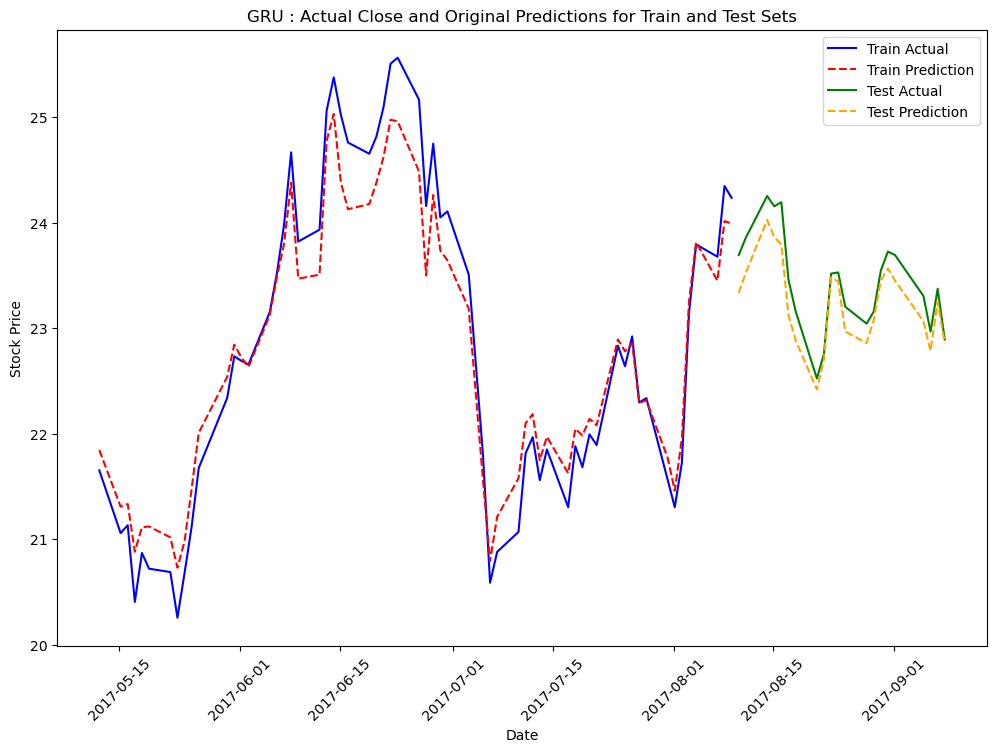

In [71]:
#plotting
plt.figure(figsize=(12, 8))

plt.plot(train_dates, train_close, label='Train Actual', color='blue')
plt.plot(train_dates, GRU_train_predictions, label='Train Prediction', color='red', linestyle='--')
plt.plot(test_dates, test_close, label='Test Actual', color='green')
plt.plot(test_dates, GRU_test_predictions, label='Test Prediction', color='orange', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('GRU : Actual Close and Original Predictions for Train and Test Sets')
plt.legend()
plt.xticks(rotation=45)
plt.show()

### MAE over Epochs


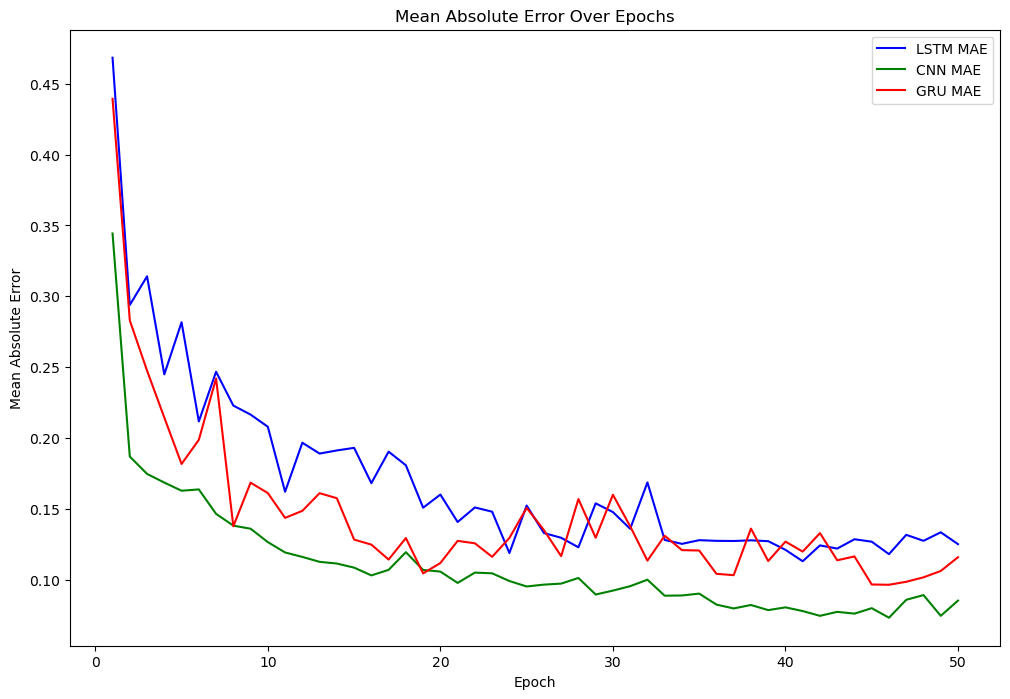

In [72]:
#mae 
mae_history_LSTM = history1.history['mae'] 
mae_history_CNN = history2.history['mae'] 
mae_history_GRU = history3.history['mae']  

#plotting all maes
plt.figure(figsize=(12, 8))
plt.plot(range(1, EPOCHS + 1), mae_history_LSTM, label='LSTM MAE', color='blue')
plt.plot(range(1, EPOCHS + 1), mae_history_CNN, label='CNN MAE', color='green')
plt.plot(range(1, EPOCHS + 1), mae_history_GRU, label='GRU MAE', color='red')

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error Over Epochs')
plt.legend()

plt.show()

### Loss over Epochs

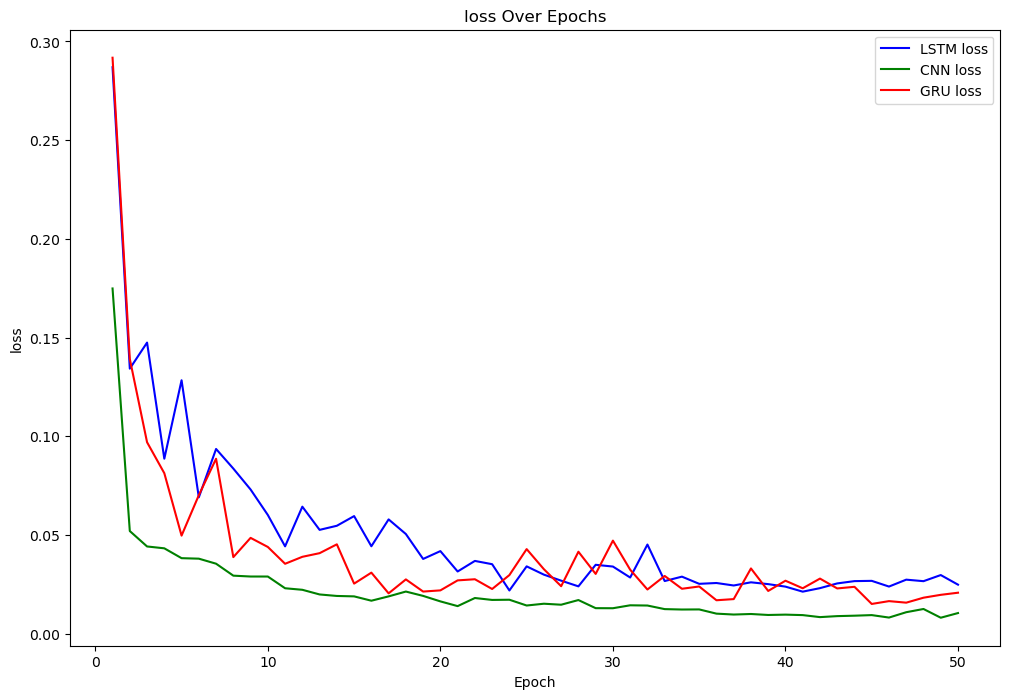

In [73]:
#loss 
loss_history_LSTM = history1.history['loss']
loss_history_CNN = history2.history['loss']
loss_history_GRU = history3.history['loss']

#plotting all loss 
plt.figure(figsize=(12, 8))

plt.plot(range(1, EPOCHS + 1), loss_history_LSTM, label='LSTM loss', color='blue')
plt.plot(range(1, EPOCHS + 1), loss_history_CNN, label='CNN loss', color='green')
plt.plot(range(1, EPOCHS + 1), loss_history_GRU, label='GRU loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('loss Over Epochs')
plt.legend()
plt.show()

## Ensemble Model

In [74]:
#creating ensemble model
lstm_predictions = LSTM_model.predict(x_test)
cnn_predictions = CNN_model.predict(x_test)
gru_predictions = GRU_model.predict(x_test)

ensemble_input = np.concatenate([lstm_predictions, cnn_predictions, gru_predictions], axis=1)
ensemble_model = Sequential(name="Ensemble_model")
ensemble_model.add(Dense(1, input_shape=(3,)))  # Output layer for regression, input_shape is (number of models,)
ensemble_model.compile(optimizer='adam', loss='mean_squared_error')
ensemble_loss = ensemble_model.evaluate(ensemble_input, y_test)

print("Ensemble Model Loss:", ensemble_loss)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


2024-05-06 13:37:28.333498: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 13:37:28.466771: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 1.8149
Ensemble Model Loss: 1.8148592710494995


2024-05-06 13:37:28.595684: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


In [76]:
Computation_time= [
    ("DT", dt_training_time, dt_prediction_time),
    ("LSTM", LSTM_training_time, LSTM_prediction_time),
    ("CNN", CNN_training_time, CNN_prediction_time),
    ("GRU", GRU_training_time, GRU_prediction_time)
]

time_df = spark.createDataFrame(Computation_time, ["Model", "Training Time", "Prediction Time"])
time_df.show()

+-----+------------------+-------------------+
|Model|     Training Time|    Prediction Time|
+-----+------------------+-------------------+
|   DT| 5.932264804840088|0.37964582443237305|
| LSTM|14.813937664031982| 0.8961780071258545|
|  CNN| 10.99051308631897| 1.1757032871246338|
|  GRU| 20.71681809425354| 1.0715341567993164|
+-----+------------------+-------------------+



In [77]:
Eval = [
    ("DT", dt_mae, dt_loss),
    ("LSTM", LSTM_mae, LSTM_loss),
    ("CNN", CNN_mae, CNN_loss),
    ("GRU", GRU_mae, GRU_loss)
]

Eval = spark.createDataFrame(Eval, ["Model", "MAE", "Loss"])
Eval.show()


+-----+-------------------+--------------------+
|Model|                MAE|                Loss|
+-----+-------------------+--------------------+
|   DT|0.23293773655083808| 0.06901639311108924|
| LSTM|0.07010997831821442|0.007735810242593288|
|  CNN|0.09224684536457062|0.014216411858797073|
|  GRU|0.06254467368125916|0.006699938327074051|
+-----+-------------------+--------------------+

